# Predicting Foaming Capacity Based on Ingredient Macronutrient Composition Using Machine Learning
Shan He · July 2025 · [GitHub](https://github.com/infoshanhe/ingredient-functionality-ml)

## Project Motivation
Current food product development is limited by trial-and-error testing. This project explores the feasibility of using macronutrient data to predict foaming capacity, one of the key functional properties in ingredient design, using machine learning techniques.

## Methods Summary
- Dataset: 86 samples from literature (78 plant-based ingredients, 8 animal ingredients)
- Features: protein%, lipid%, carbohydrates%, fiber%, sample concentration%
- Models used: linear regression, elastic net, random forest
- Tools: Python (scikit-learn, pandas, matplotlib), assisted by Github Copilot

## Key Findings
- Best model (linear regression with feature interaction) achieved R² = 0.77
- Plant-based ingredients need to be modeled separately from animal-based ingredients
- Sample concentration% and protein% were the strongest predictors
- Linear models showed high multicollinearity between proteins and carbohydrates

## 1. Introduction
In this project, we tried to model food ingredients foamability based on macronutrient composition.

The approach taken in this project is to manually collect literature data on foamability and respective material macronutrient composition, and used machine learning techniques to explore the relationship.

Initially, large food databases such as FooDB and USDA FoodData were investigated to explore the feasibility of using their data for foamability prediction. However, it was a challenge to match the ingredients with the materials commonly used in foamability experiments. For example, the database may have an entry on "green pea", but experimental results on foamability is based on "pea protein isolate".

Therefore, a dataset of 86 samples was collected and stored in this [Excel](https://github.com/infoshanhe/ingredient-functionality-ml/blob/main/cleaned_data.xlsx) with information below:
- Sample concentration (%): the w/w concentration of sample solution in literature
- Macronutrients: the dry weight percentage of sample from literature
    - Protein (%)
    - Lipid (%)	
    - Carbohydrates (%)	
    - Fiber (%)	
    - Ash (%)	
- Foaming Capacity (%): experimental results from literature

Linear regression, elastic net and random forest were applied due to the limited size of the dataset.

## 2. Linear Regression with all samples (86 samples)
Due to the low sample number, cross-validation was performed to maximize the amount of data being used in modeling.
The mean $R^2$ at 0.23 is very low. In the next step, the outliers are investigated.

In [1]:
# Imports
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNetCV, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import (KFold, cross_val_predict, cross_val_score,
                                     cross_validate)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import foaming_capacity_ml_utils as utils


In [2]:
def load_df():
    """Load the cleaned dataset."""
    file_path = "cleaned_data.xlsx"
    excel_file = pd.ExcelFile(file_path)
    df = excel_file.parse('cleaned_data')
    return df


df = load_df()

# Select features and target, Ash% is excluded to prevent multicollinearity
X = df[['Sample concentration (%)', 'Protein (%)', 'Lipid (%)', 'Carbohydrates (%)', 'Fiber (%)','Plant ingredient?']]
y = df['Foaming Capacity (%)']

imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
pipeline = Pipeline(steps=[
    ('imputer', imputer),
    ('scaler', scaler),
    ('model', LinearRegression())
])

# Perform cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='r2')
print("Cross-validated R² scores:", scores)
print(f"Mean R²: {scores.mean():.2f}")

Cross-validated R² scores: [ 0.68210437  0.20039023  0.03626382  0.72640985 -0.48167635]
Mean R²: 0.23


### 2.1 Inspect outliers
We analyzed outliers, defined as points whose absolute residuals are high (>2 std. dev). We found that all the outliers are samples of animal origin, therefore, we exclude animal samples from further analysis.


In [3]:
# Get cross-validated predictions (each point is predicted by a model that didn't see it)
y_pred_cv = cross_val_predict(pipeline, X, y, cv=cv)
residuals = y - y_pred_cv
std_residuals = residuals / residuals.std()

# Define outliers as those with standardized residuals with an absolute value greater than 2
outlier_mask = np.abs(std_residuals) > 2

utils.print_outliers(outlier_mask, y_pred_cv, X, y, residuals)

Printing info on outliers:

Number of outliers: 3

Is plant ingredient? 0 = False, 1 = True
2     0
3     0
35    0
Name: Plant ingredient?, dtype: int64

True values:
2      89.68
3      39.68
35    459.10
Name: Foaming Capacity (%), dtype: float64

Predicted values:
2     217.875654
3     165.402349
35    102.695561
dtype: float64

Residuals:
2    -128.195654
3    -125.722349
35    356.404439
Name: Foaming Capacity (%), dtype: float64


## 3. Linear regression with plant samples (78)
The linear regression model achieved a substantially improved mean $R^2$ of 0.72 when applied exclusively to plant-based ingredients (n = 78), compared to the model trained on the full dataset. This indicates a stronger and more consistent relationship between macronutrient composition and foaming capacity within plant ingredients. The features with the highest coefficient is protein %.

The current dataset is heavily skewed toward plant-based ingredients, with only a small number of animal-based samples (n = 8). Although the animal-based samples are few, the observed improvement in model performance suggests that plant and animal ingredients should be modeled separately, as they exhibit distinct macronutrient profiles, particularly in terms of protein, lipid, and carbohydrate composition, which likely influence their foaming behavior differently.

Next step: To enable a more robust and meaningful analysis of animal-derived ingredients, a larger and more diverse set of animal-based samples should be collected. This would allow for separate modeling of the macronutrient–functionality relationship in animal ingredients to reduce bias caused by the current sample imbalance.

In [4]:
df = load_df()
filtered_df = df[df['Plant ingredient?'] == 1]
print(f'Number of samples with plant ingredients: {len(filtered_df)}')
# Select features and target, Ash% dropped for multicollinearity
X_filtered = filtered_df[['Sample concentration (%)', 'Protein (%)', 'Lipid (%)', 'Carbohydrates (%)', 'Fiber (%)']]
y_filtered = filtered_df['Foaming Capacity (%)']

# 5-fold cross-validation on training data
scores_filtered = cross_val_score(pipeline, X_filtered, y_filtered, cv=cv, scoring='r2')
cv_results = cross_validate(pipeline, X_filtered, y_filtered, cv=cv, scoring='r2', return_estimator=True)

# Print results
print("Cross-validated R² scores:", scores_filtered)
print(f"Mean R²: {scores_filtered.mean():.2f}")

Number of samples with plant ingredients: 78
Cross-validated R² scores: [0.59759733 0.62287436 0.71892025 0.89099672 0.7808512 ]
Mean R²: 0.72


In [5]:
utils.print_per_fold_coefficients(cv_results, feature_names=X_filtered.columns)

Per-fold coefficients:

Fold 1 R²: 0.60
  Sample concentration (%): 24.25
  Protein (%): 46.14
  Lipid (%): -9.89
  Carbohydrates (%): 19.52
  Fiber (%): 9.17

Fold 2 R²: 0.62
  Sample concentration (%): 23.65
  Protein (%): 67.66
  Lipid (%): -6.46
  Carbohydrates (%): 39.06
  Fiber (%): 12.55

Fold 3 R²: 0.72
  Sample concentration (%): 25.22
  Protein (%): 50.22
  Lipid (%): -5.69
  Carbohydrates (%): 23.45
  Fiber (%): 11.20

Fold 4 R²: 0.89
  Sample concentration (%): 23.52
  Protein (%): 52.04
  Lipid (%): -7.60
  Carbohydrates (%): 24.15
  Fiber (%): 10.21

Fold 5 R²: 0.78
  Sample concentration (%): 25.41
  Protein (%): 48.77
  Lipid (%): -7.48
  Carbohydrates (%): 20.62
  Fiber (%): 9.76


### 3.1 Standard error coefficients
The standard error for the coefficients are especially high for protein% and carbohydrates%. This indicates instability for the model, mainly due to the limited sample size in combination with the high correlation between these 2 variables (causing a high degree of multicollinearity). 

For many plant ingredients, the difference in composition mainly reflects in protein and carbohydrates, as they are most often the largest components for plant-based food ingredients on a dry weight basis. 

Mean coefficient values: [24.40829429 52.96664085 -7.42172308 25.35907489 10.57997236]
Standard error of coefficients: [0.39014881 3.79848173 0.70848287 3.53115017 0.59283151]


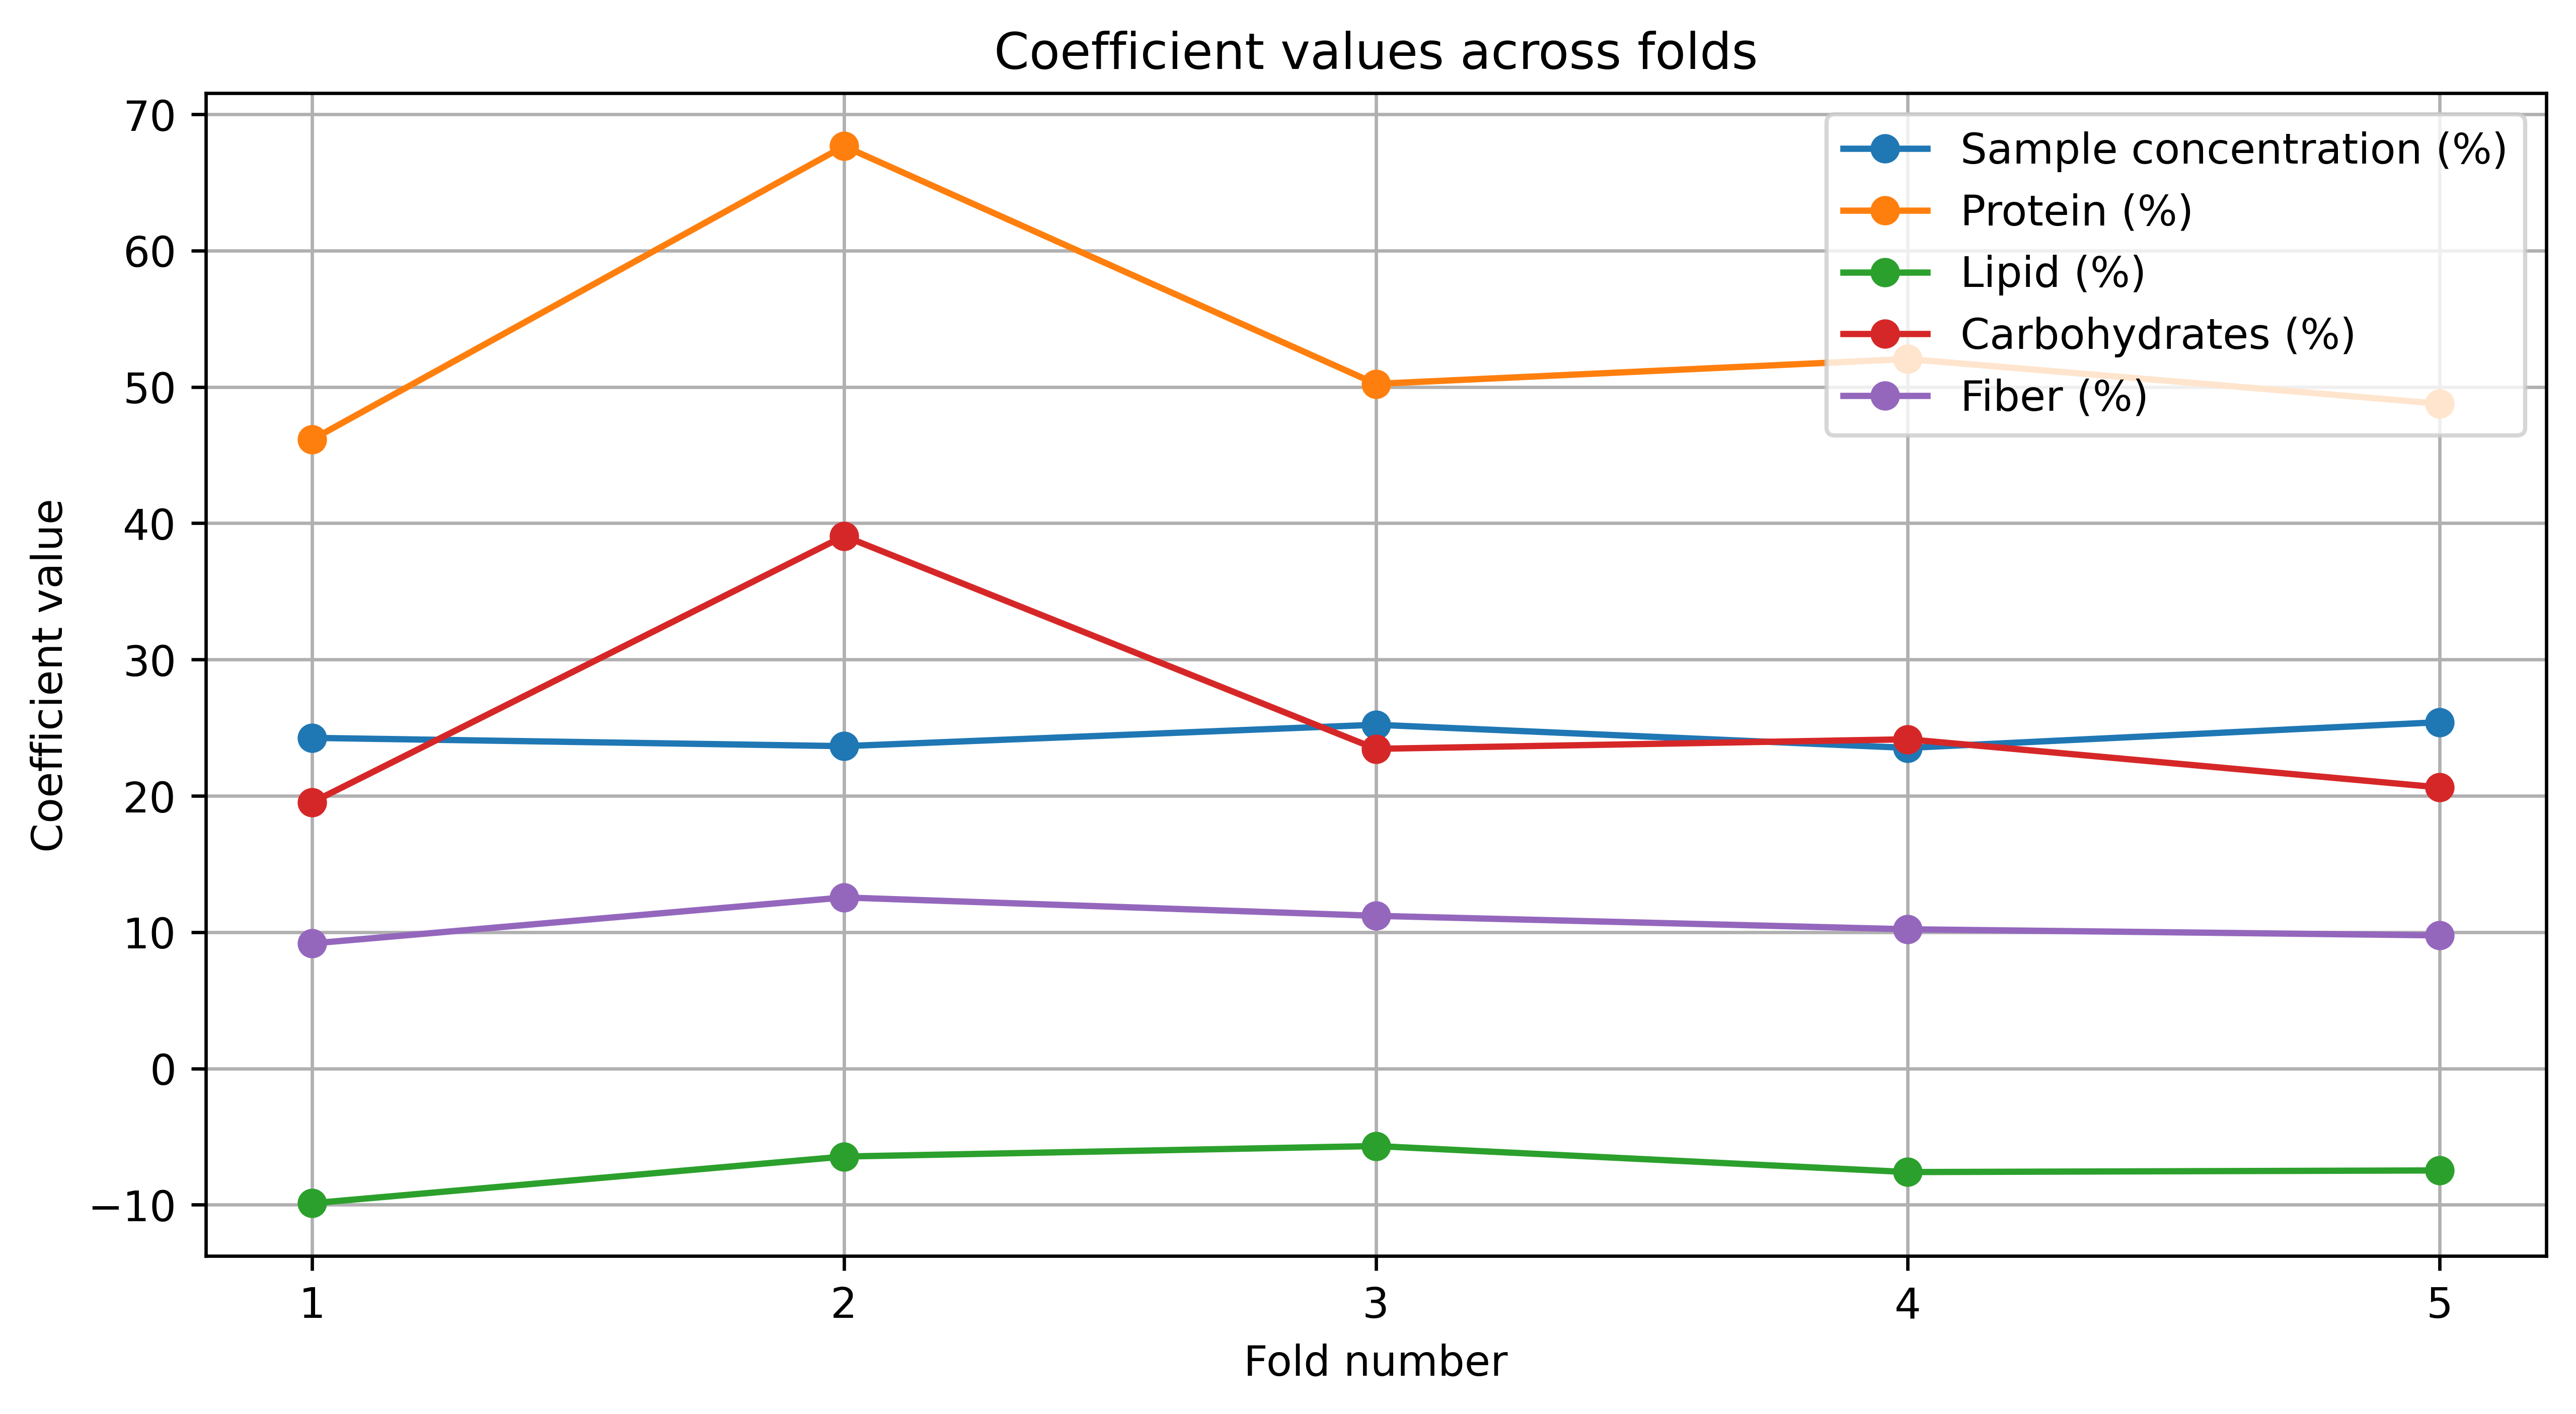

In [6]:
utils.print_and_plot_coef_values(cv_results, feature_names=X_filtered.columns)

### 3.2 Multicollinearity
There is multicollinearity between carbohydrates and protein (-0.95 Pearson correlation). Carbohydrates and protein are often the largest component of plant based food ingredients, which partly explains this phenomenon. The model was also fitted without carbohydrates as a feature, but the mean $R^2$ turned out to be similar with the above. The results are not shown in this document.

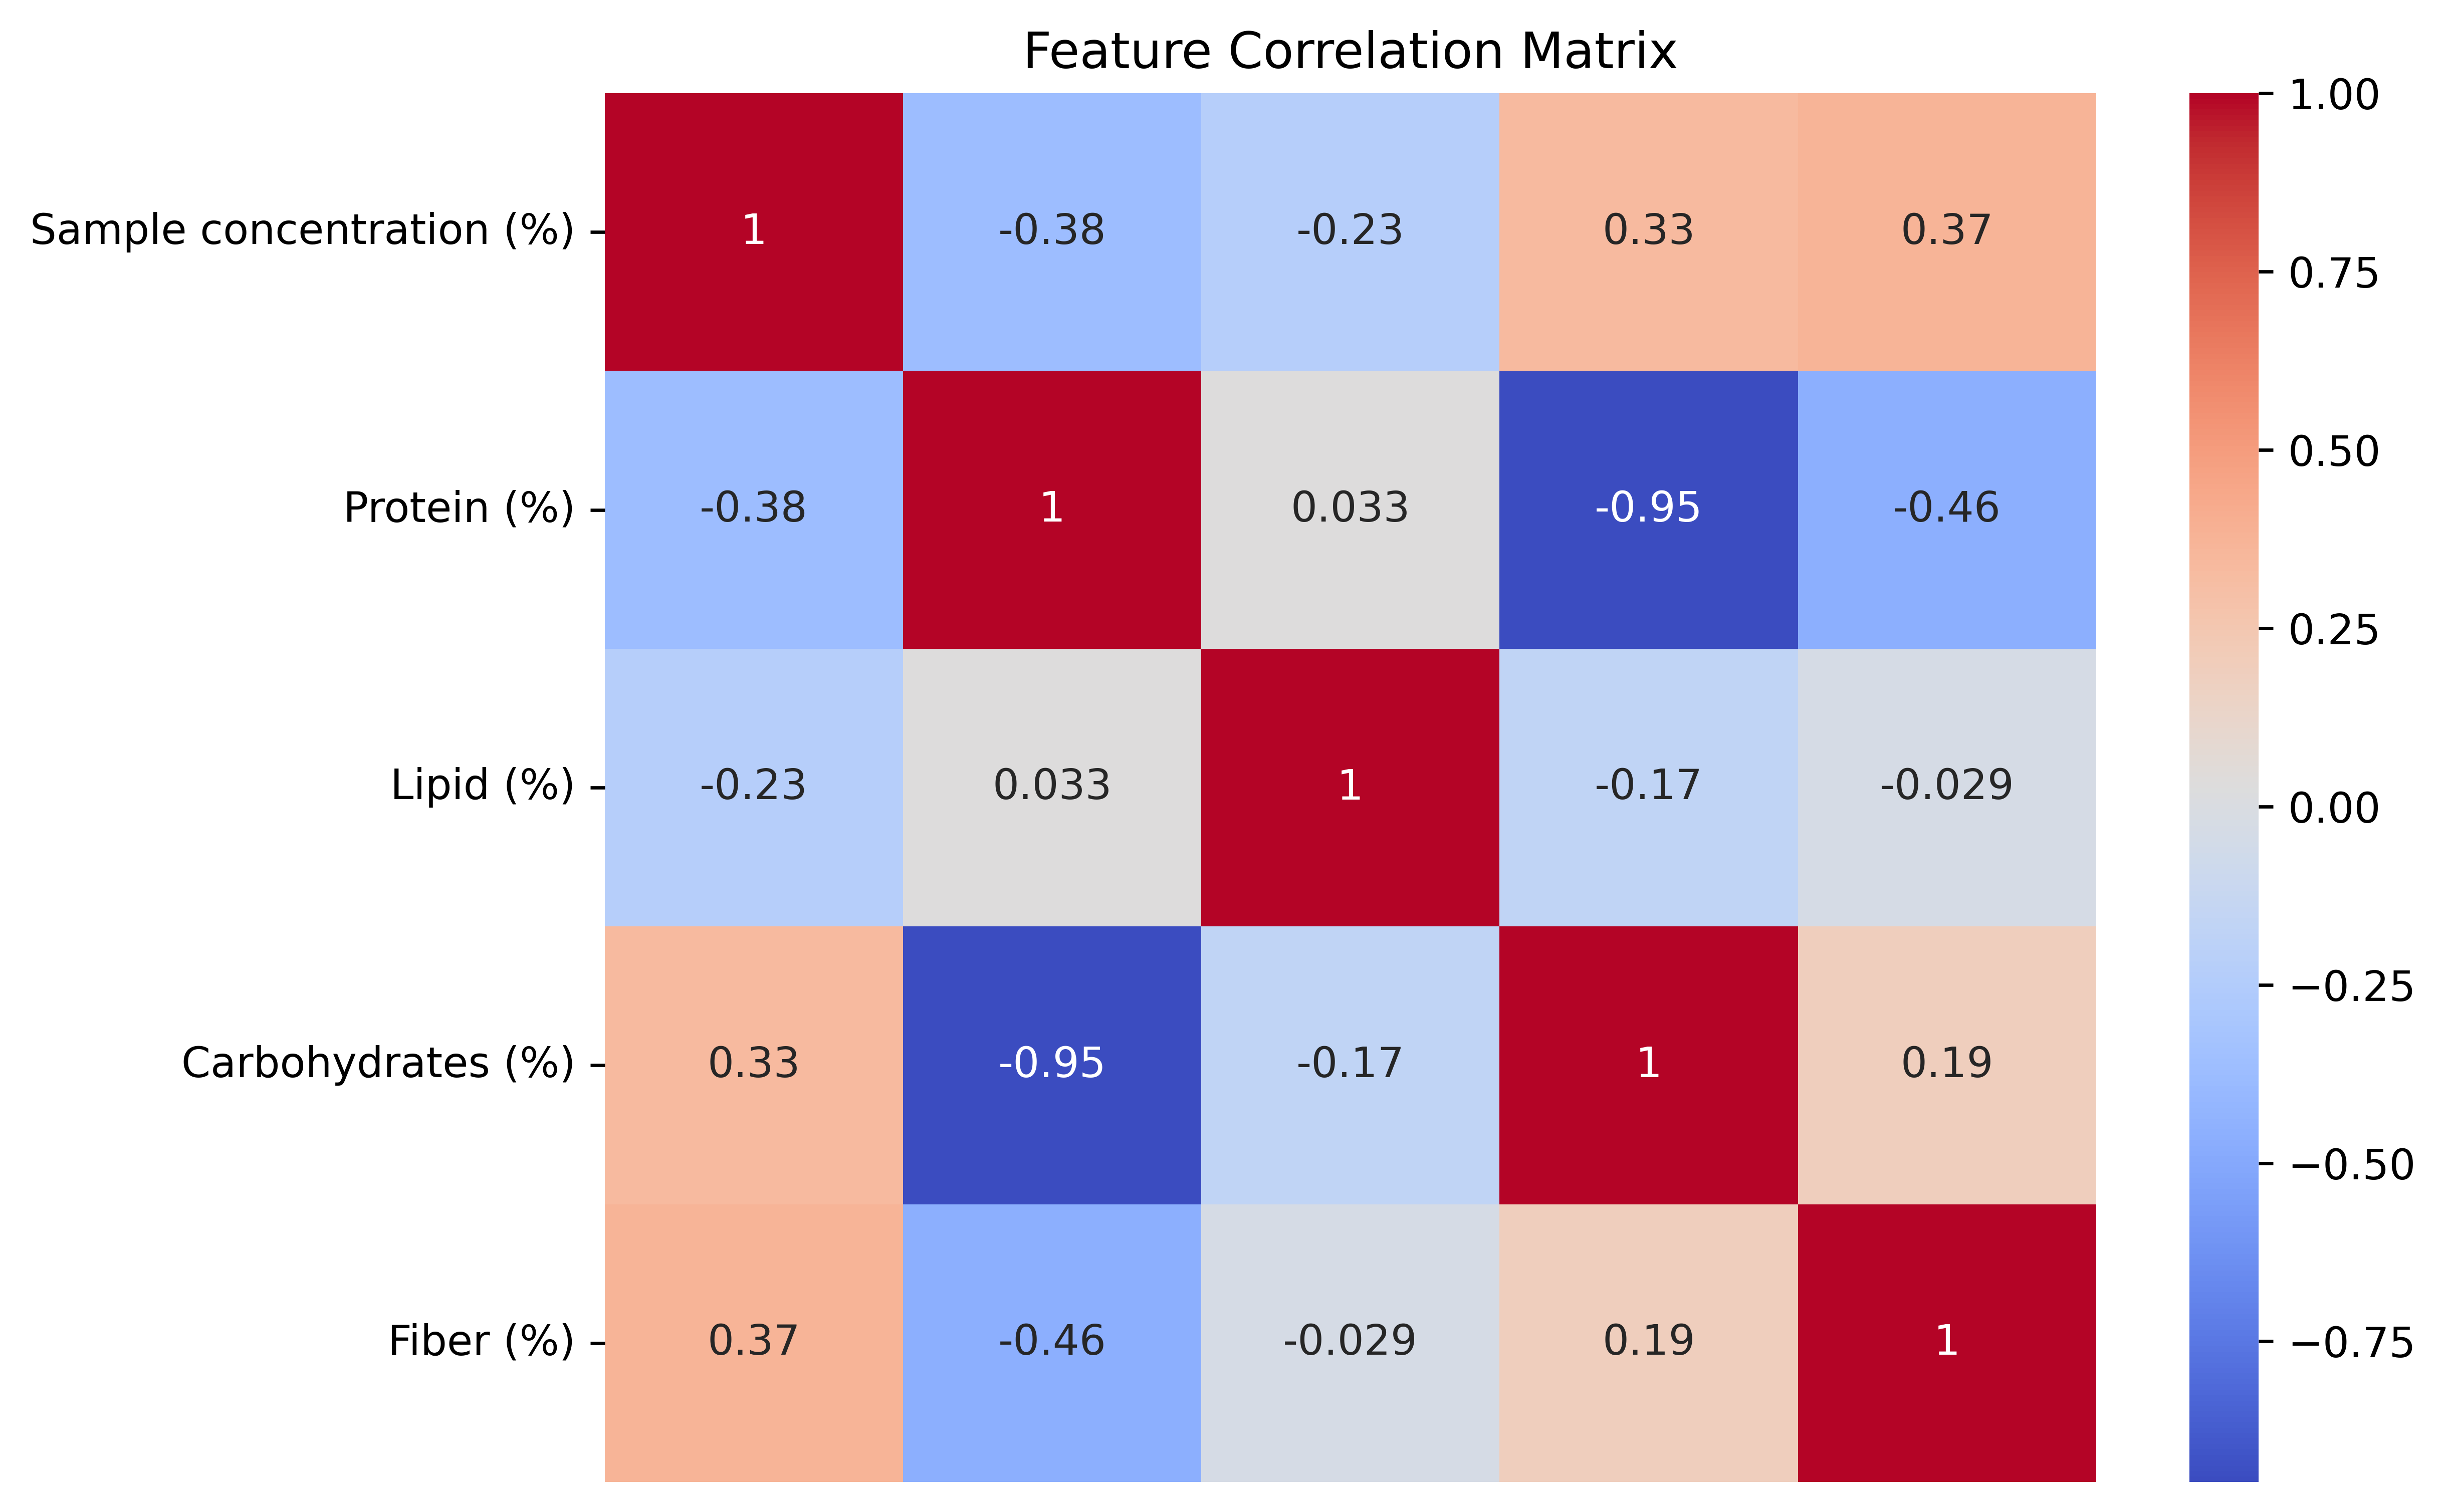

In [7]:
utils.plot_feature_correlation_matrix(X_filtered)

### 3.3 Regularization using ElasticNetCV
When using small datasets, regularization often improves prediction performance by preventing overfitting. However, the improvement observed here is minimal.

In [8]:
# ElasticNetCV automatically tunes alpha and l1_ratio using cross-validation
elastic_net = ElasticNetCV(cv=cv, random_state=42, l1_ratio=[.1, .5, .7, .9, .95, .99, 1], alphas=100)
elastic_net_pipeline = Pipeline(steps=[
    ('imputer', imputer),
    ('scaler', scaler),
    ('model', elastic_net)
])

scores_en = cross_val_score(elastic_net_pipeline, X_filtered, y_filtered, cv=cv, scoring='r2')
print("Elastic Net cross-validated R² scores:", scores_en)
print(f"Elastic Net mean R²: {scores_en.mean():.2f}")

Elastic Net cross-validated R² scores: [0.59285889 0.62733482 0.71912819 0.88806908 0.7630311 ]
Elastic Net mean R²: 0.72


## 4. Random forest
A random forest was also used to model the dataset. Cross-validation was not used here since each of the random forest trees has only looked at a subset of the data, this allows for "out-of-bag" prediction, where only trees are used to predict samples that they have not seen in training, to indicate modeling performance (similar to cross-validation).

Random forest performs better than linear regression with a high $R^2$ at 0.76. This can be due to some non-linear relationship between macronutrient composition and foaming capacity that is captured in the random forest model.

In [9]:
# Select features and target
df = load_df()
filtered_df = df[df['Plant ingredient?'] == 1]

X_rf = filtered_df[['Sample concentration (%)', 'Protein (%)', 'Lipid (%)', 'Carbohydrates (%)', 'Fiber (%)', 'Ash (%)']]
y_rf = filtered_df['Foaming Capacity (%)']

imputer = SimpleImputer(strategy='mean')

X_rf_processed = imputer.fit_transform(X_rf)
X_rf_processed = pd.DataFrame(X_rf_processed, columns=X_rf.columns)
# Train RandomForest directly on processed data
rf_model = RandomForestRegressor(n_estimators=1000, oob_score=True, random_state=42)
rf_model.fit(X_rf_processed, y_rf)

pred = rf_model.oob_prediction_
mse = mean_squared_error(y_rf, pred)
r2 = r2_score(y_rf, pred)

print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.2f}")

MSE: 336.24
R²: 0.76


### 4.1 Random forest Feature Importance
In the random forest model, the Sample concentration (%) feature has the strongest importance, followed by protein% and carbohydrates%. This is different from the linear regression, where protein% has the highest coefficient. It is likely that Sample concentration has non-linear interaction effects with the other variables, making it the most important feature in the random forest model. 

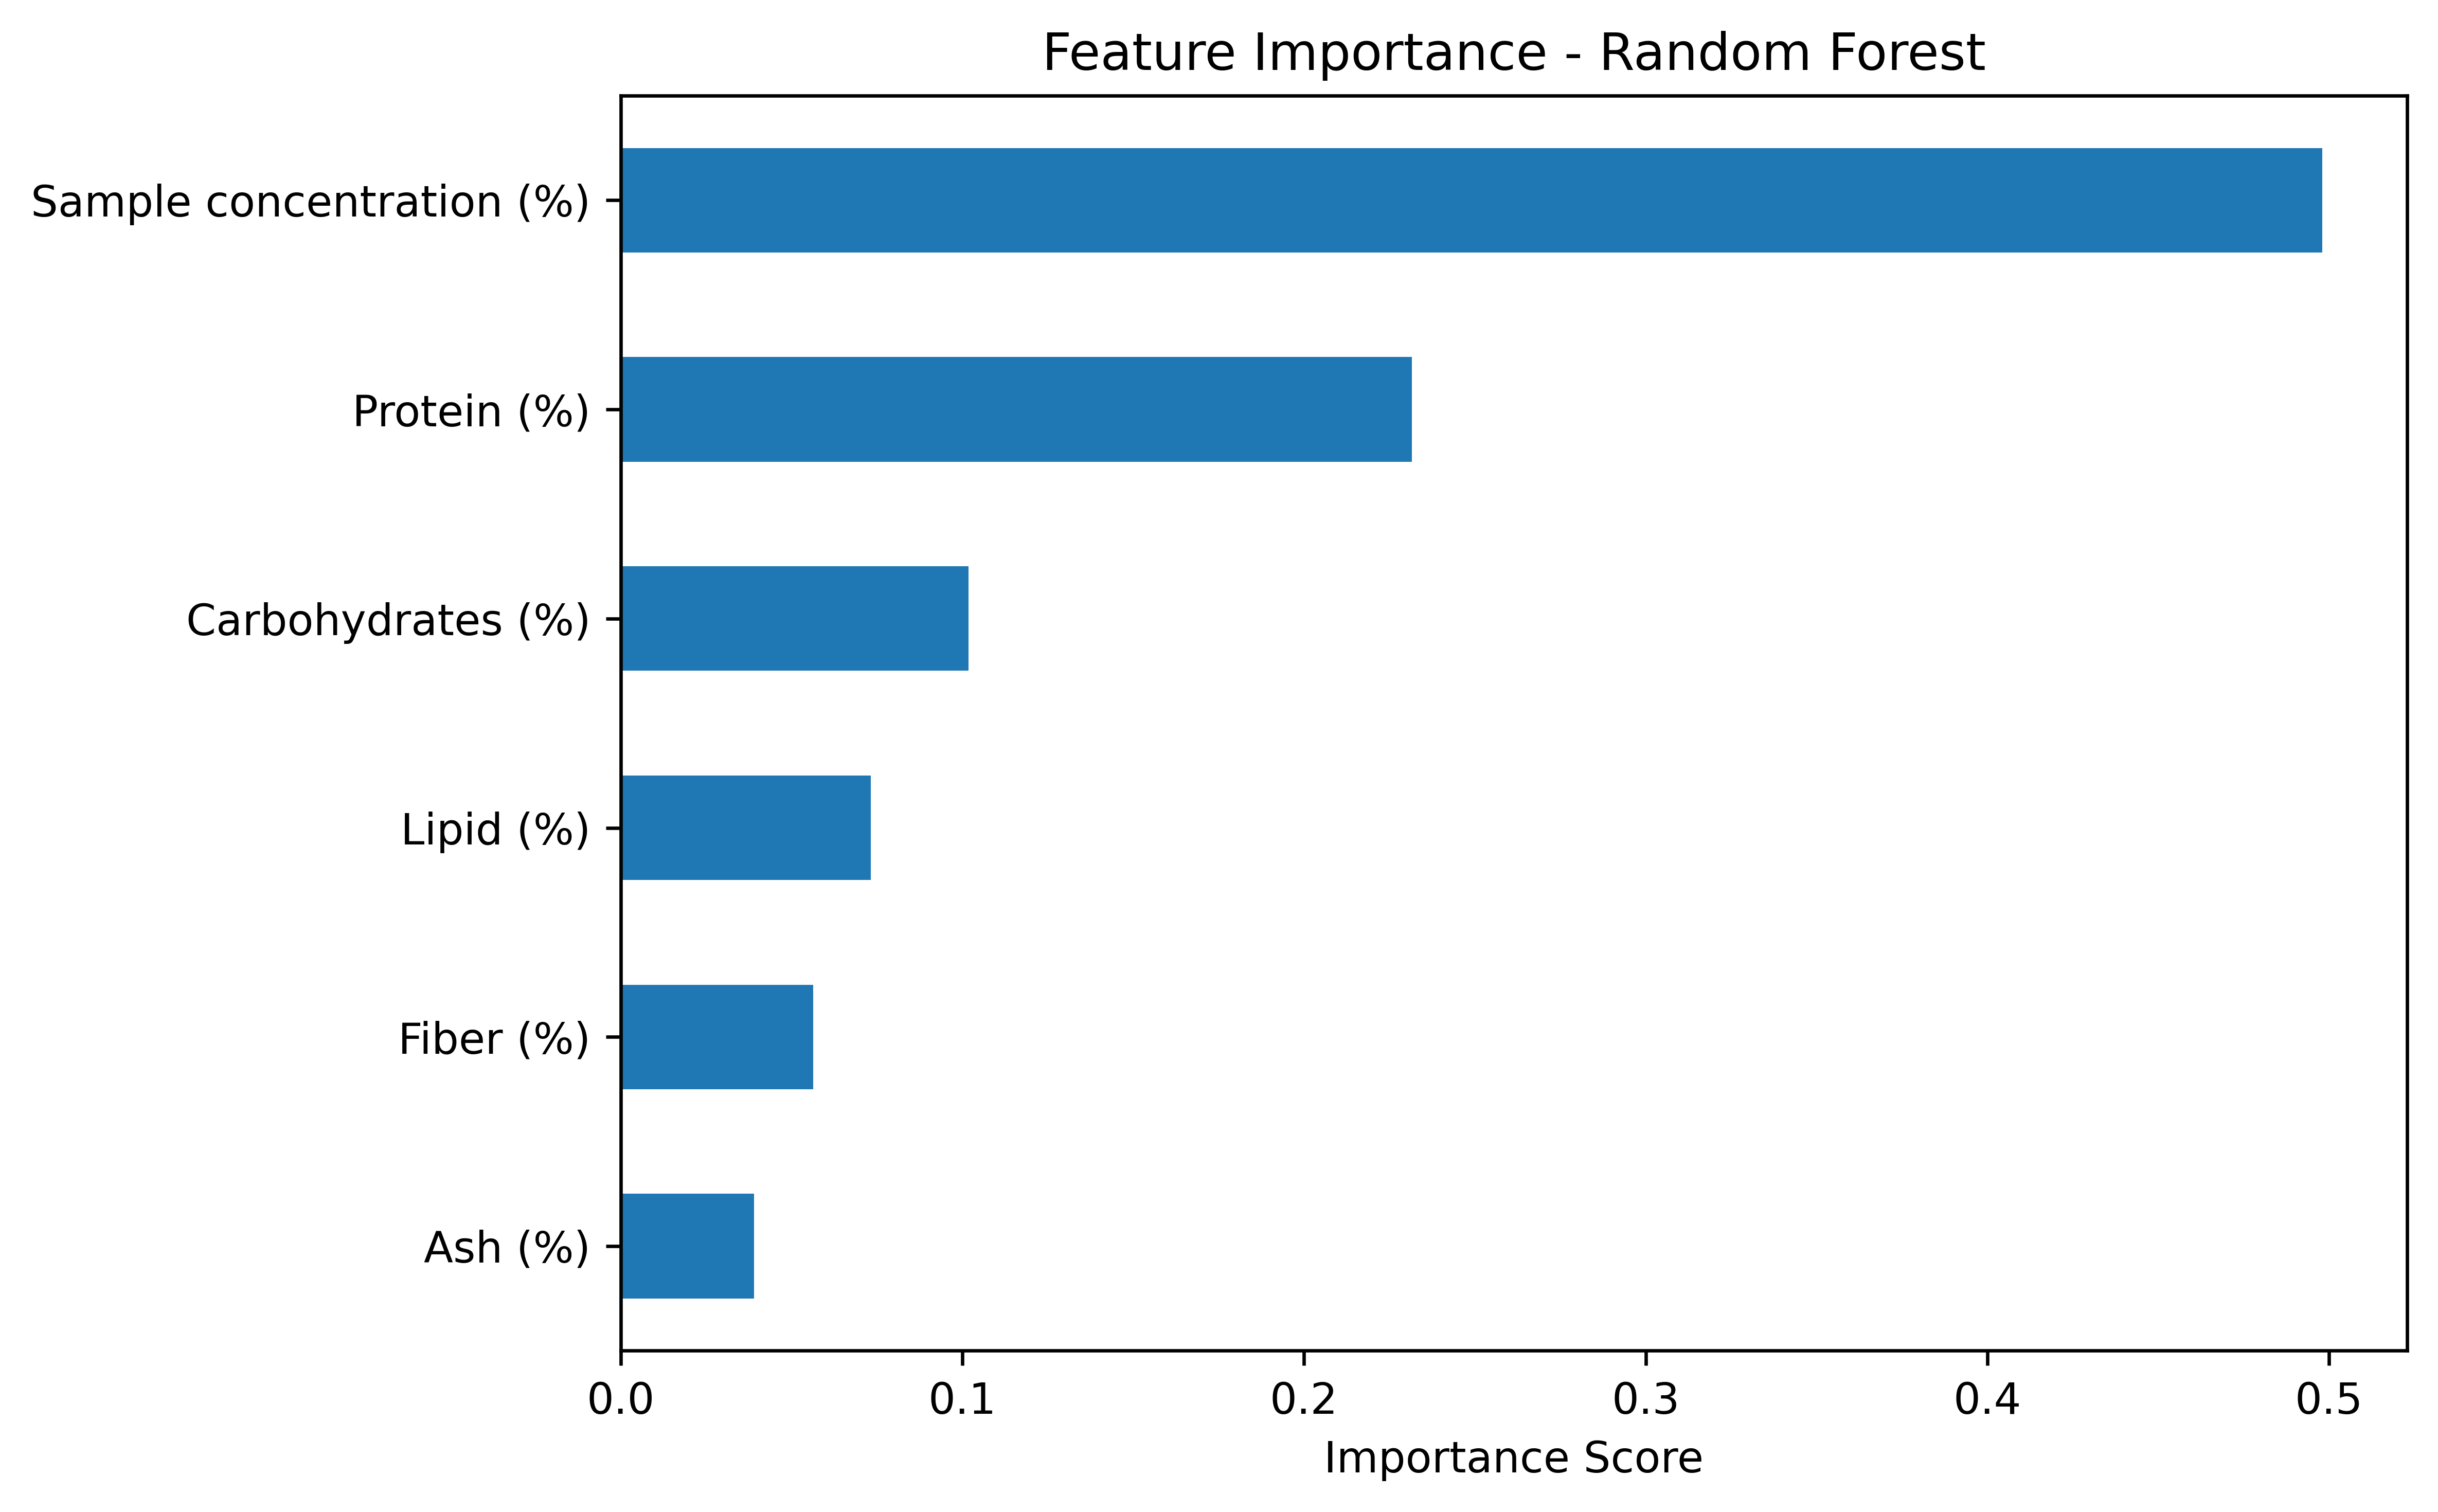

In [10]:
utils.plot_rf_importances(rf_model)

## 5. Interactions between the macronutrients features in linear regression model
Sample concentration (%) was multiplied by other features to model non-linear effects in the original linear regression model.

$R^2$ was improved to 0.77, which indicates that there are interactions between sample concentration and the macronutrients.

Now the coefficient of sample concentration (%) and protein (%) both have high absolute values. In linear regression model without feature interations, the importance of sample concentration (%) might have been dampened. The positive influence of sample concentration (%) itself was partly set off by the negative influence of sample concentration (%) x other features as can be seen from the diagram below.

Number of samples with plant ingredients: 78
Cross-validated R² scores: [0.56918005 0.76284711 0.7964185  0.88854028 0.84682641]
Mean R²: 0.77
Mean coefficient values: [ 52.37155678  52.80606908  -3.28861797  25.77105214  28.36731065
  -6.93581468 -12.13198637  -6.55177047 -27.34304747]
Standard error of coefficients: [3.74657733 2.25200088 0.77462505 1.9373405  1.15190357 1.77948464
 2.83760466 0.82719466 1.96032116]


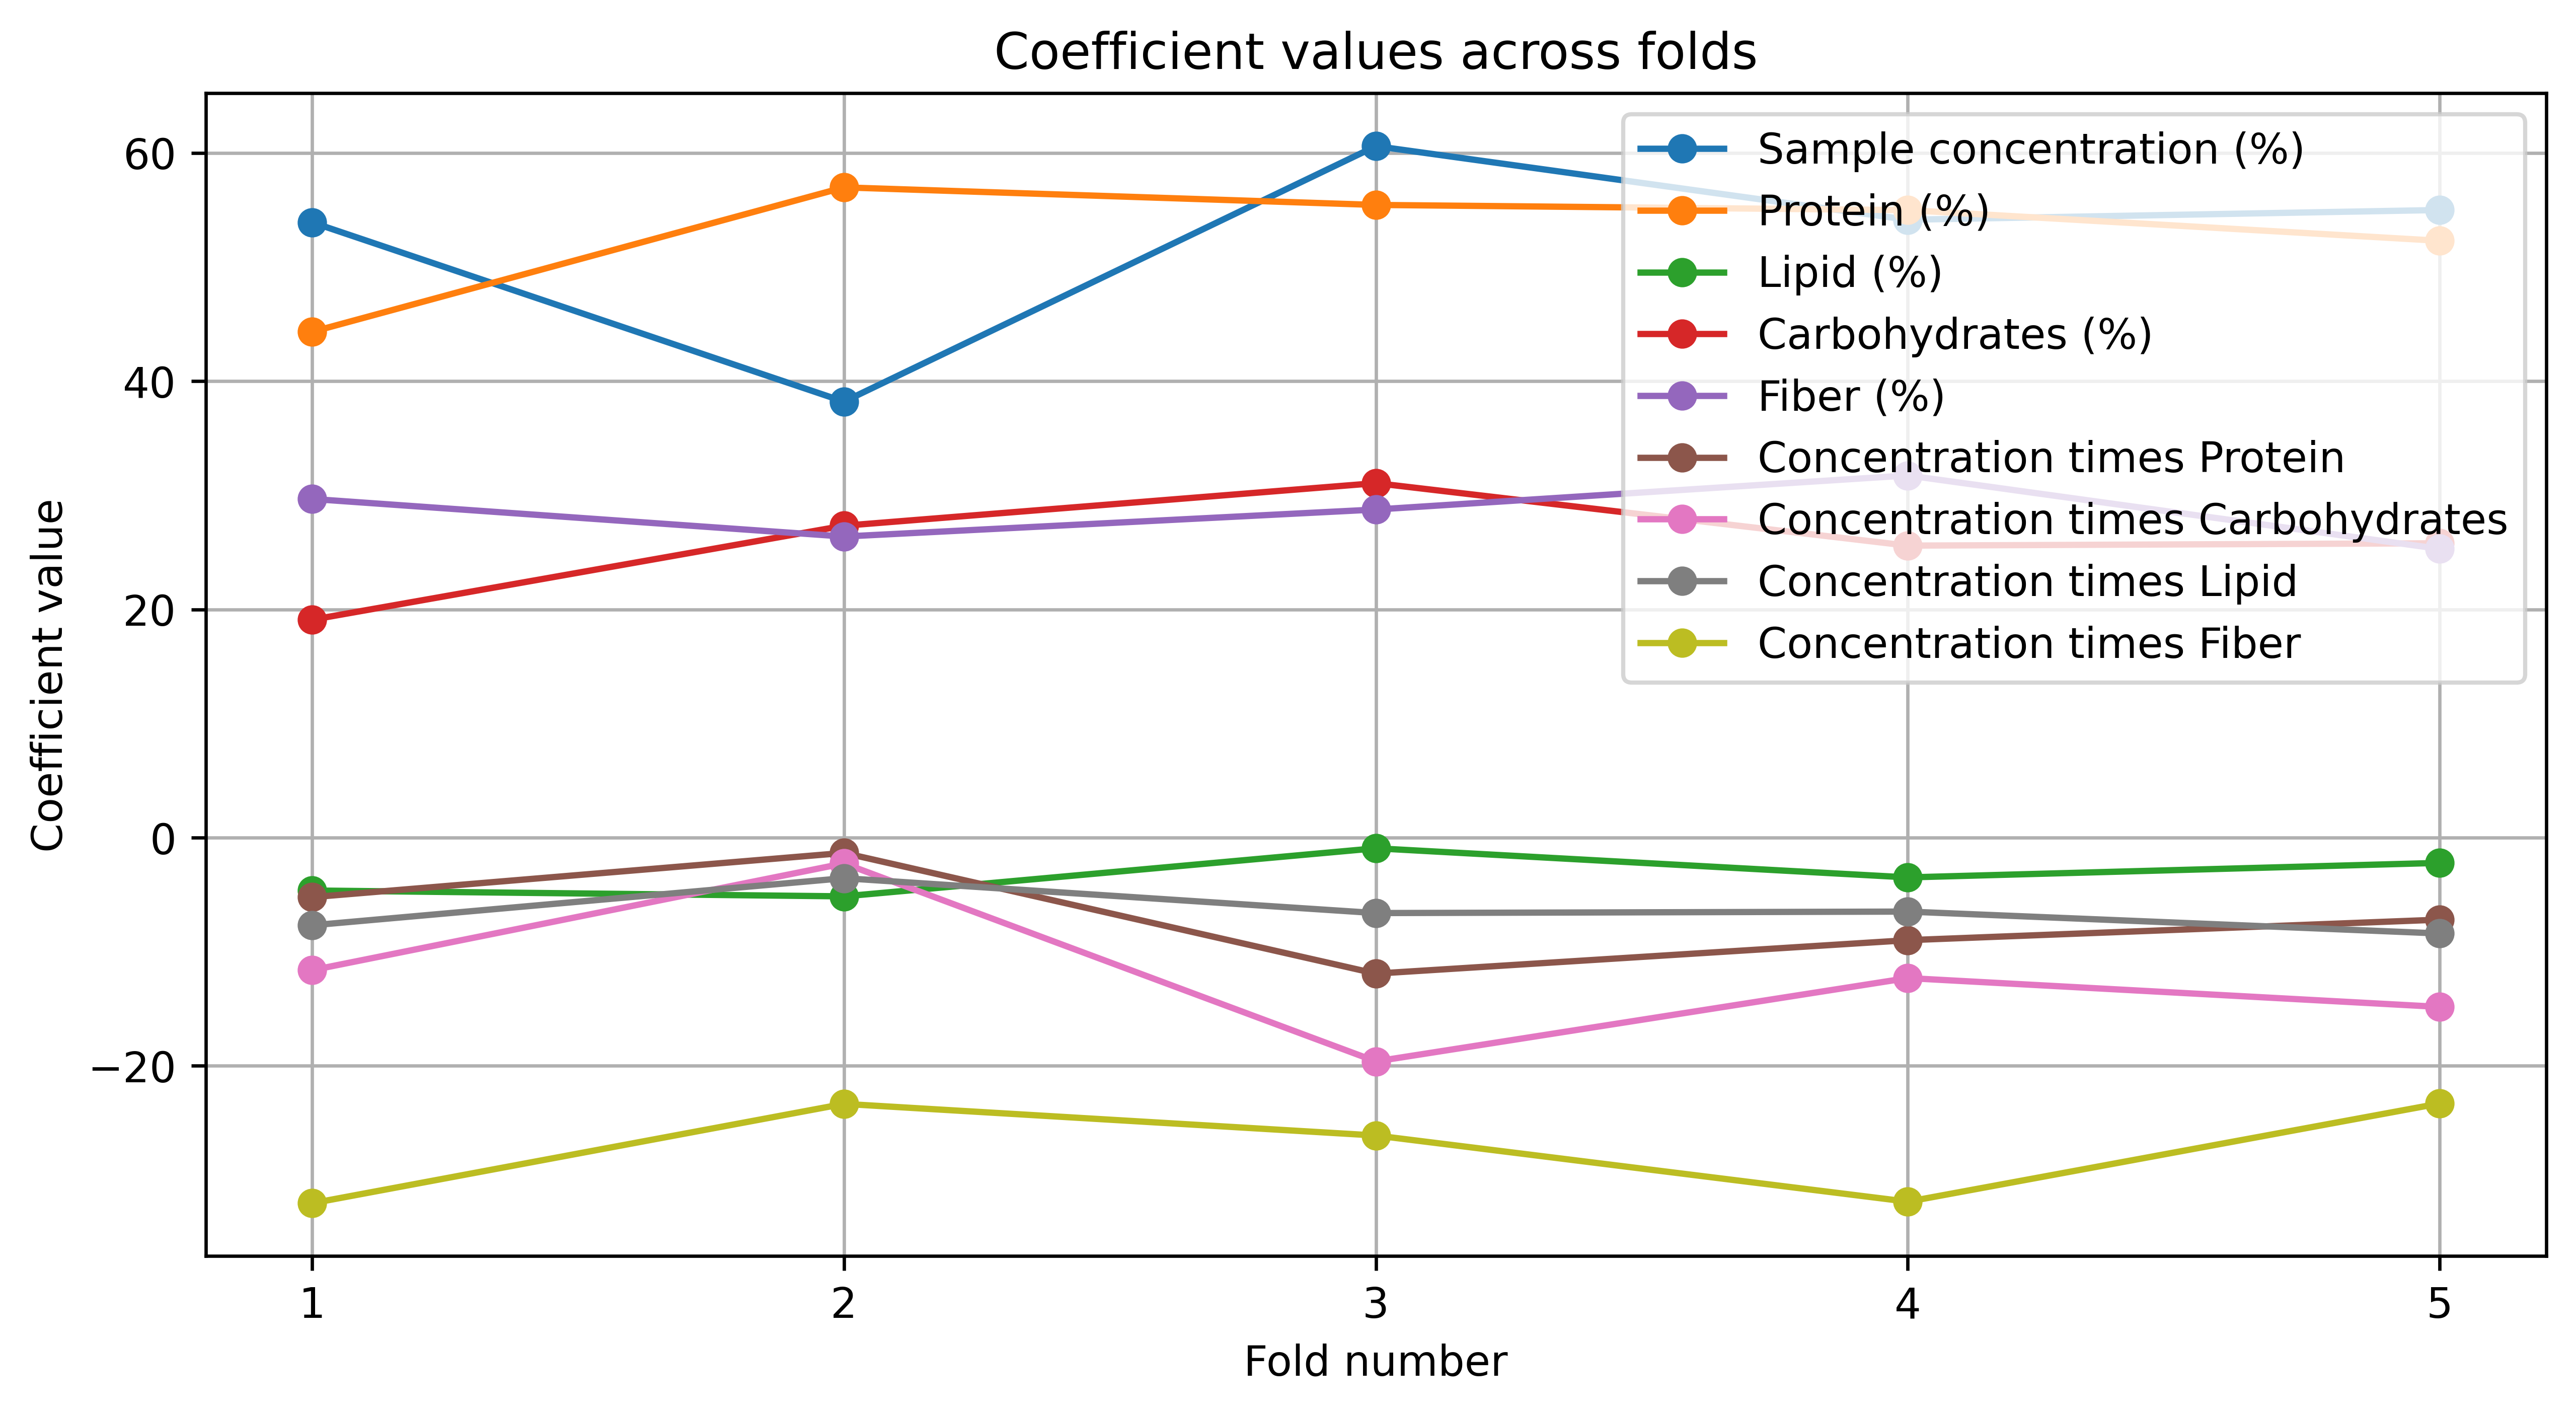

Index(['Sample concentration (%)', 'Protein (%)', 'Lipid (%)',
       'Carbohydrates (%)', 'Fiber (%)', 'Concentration times Protein',
       'Concentration times Carbohydrates', 'Concentration times Lipid',
       'Concentration times Fiber'],
      dtype='object')


In [11]:
df = load_df()
filtered_df = df[df['Plant ingredient?'] == 1]
print(f'Number of samples with plant ingredients: {len(filtered_df)}')
# Select features and target, Ash% dropped for multicollinearity
X_filtered = filtered_df[['Sample concentration (%)', 'Protein (%)', 'Lipid (%)', 'Carbohydrates (%)', 'Fiber (%)']].copy()
y_filtered = filtered_df['Foaming Capacity (%)']

X_filtered['Concentration times Protein'] = X_filtered['Sample concentration (%)'] * X_filtered['Protein (%)']
X_filtered['Concentration times Carbohydrates'] = X_filtered['Sample concentration (%)'] * X_filtered['Carbohydrates (%)']
X_filtered['Concentration times Lipid'] = X_filtered['Sample concentration (%)'] * X_filtered['Lipid (%)']
X_filtered['Concentration times Fiber'] = X_filtered['Sample concentration (%)'] * X_filtered['Fiber (%)']

# 5-fold cross-validation on training data
scores_filtered = cross_val_score(pipeline, X_filtered, y_filtered, cv=cv, scoring='r2')
cv_results = cross_validate(pipeline, X_filtered, y_filtered, cv=cv, scoring='r2', return_estimator=True)

# Print results
print("Cross-validated R² scores:", scores_filtered)
print(f"Mean R²: {scores_filtered.mean():.2f}")

utils.print_and_plot_coef_values(cv_results, feature_names=X_filtered.columns)
print(X_filtered.columns)

## 6. Final linear regression model

The following model estimates foaming capacity as a function of macronutrient composition and interaction terms, with coefficients reported alongside their standard errors (±SE).
The linear regression formula to predict foaming capability (y) based on macronutrients is: \
Foaming Capacity (%) = -135.89 (±80.71) + 36.70 (±22.68) × Sample concentration (%) + 1.84 (±0.88) × Protein (%) + -0.94 (±1.25) × Lipid (%) + 1.03 (±0.87) × Carbohydrates (%) + 3.30 (±0.89) × Fiber (%) + -0.11 (±0.25) × Concentration times Protein + -0.16 (±0.24) × Concentration times Carbohydrates + -0.64 (±0.44) × Concentration times Lipid + -0.75 (±0.26) × Concentration times Fiber \
\
The Python package for modeling was changed to obtain statistical results.

Protein (%), Fiber (%), and Sample Concentration times Fiber are the most important statistically significant coefficients with p-values less than 0.05.

In [12]:
X_filtered_imputed = imputer.fit_transform(X_filtered)
X_filtered_imputed = pd.DataFrame(X_filtered_imputed, columns=X_filtered.columns, index=X_filtered.index)
X_with_const = sm.add_constant(X_filtered_imputed, has_constant='add')  # add intercept, keep DataFrame structure
model = sm.OLS(y_filtered, X_with_const).fit()

# Print summary
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     Foaming Capacity (%)   R-squared:                       0.804
Model:                              OLS   Adj. R-squared:                  0.778
Method:                   Least Squares   F-statistic:                     31.06
Date:                  Sun, 13 Jul 2025   Prob (F-statistic):           9.60e-21
Time:                          20:01:20   Log-Likelihood:                -330.25
No. Observations:                    78   AIC:                             680.5
Df Residuals:                        68   BIC:                             704.1
Df Model:                             9                                         
Covariance Type:              nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [13]:
coefs = model.params
std_errs = model.bse

formula_terms = [
    f"{coef:.2f} (±{se:.2f}) × {var}" if var != "const" else f"{coef:.2f} (±{se:.2f})"
    for var, coef, se in zip(coefs.index, coefs.values, std_errs.values)
]

formula = " + ".join(formula_terms)
print("Foaming Capacity (%) =", formula)

Foaming Capacity (%) = -135.89 (±80.71) + 36.70 (±22.68) × Sample concentration (%) + 1.84 (±0.88) × Protein (%) + -0.94 (±1.25) × Lipid (%) + 1.03 (±0.87) × Carbohydrates (%) + 3.30 (±0.89) × Fiber (%) + -0.11 (±0.25) × Concentration times Protein + -0.16 (±0.24) × Concentration times Carbohydrates + -0.64 (±0.44) × Concentration times Lipid + -0.75 (±0.26) × Concentration times Fiber
